# Can you help reduce employee turnover?

## 📖 Background
You work for the human capital department of a large corporation. The Board is worried about the relatively high turnover, and your team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, you can present your findings along with your ideas on how to attack the problem.

## 💾 The data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.

I start by taking a look at the data type and structure. There seem to be no null values, and the data types make sense.   

In [1]:
#importing relevant packages:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.set_printoptions(precision=5, suppress = True)

import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn import svm

from mpl_toolkits.mplot3d import Axes3D

In [2]:
#loading data:
df_raw = pd.read_csv('./data/employee_churn_data.csv')

# visualizing data columns 
#df_raw.head()
#df_raw.isnull().sum()

# looking at data types:
df_raw.info()

#looking at unique values in each datatype:
df_raw.nunique()

#normalizing all quantitaive data:
df = df_raw.copy()

quant_vars = ['review', 'tenure', 'satisfaction', 'avg_hrs_month']

for i in quant_vars:
    df[i] = (df[i] - df[i].mean()) / df[i].std()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


## 1. Exploratory Data Analysis (EDA)

For EDA, I have divided the data into two sections: employees that have left ("yes") and the employpees that are still in the company ("no"). I then plot the normalized distribution over each variable for the two sections. I assume that if the distribution of "yes" and "no" employees is different for the same values (or the same bins) of a given variable, then that variable is of interest to the problem.


Using this graph, I can make some cursory remarks:

From the graphs, we can see that some departments are more likely to lose their employess than other.
Promoted employees are less likely to leace a company.
Higher reviewd employees tend to leave the company at a higher rate.


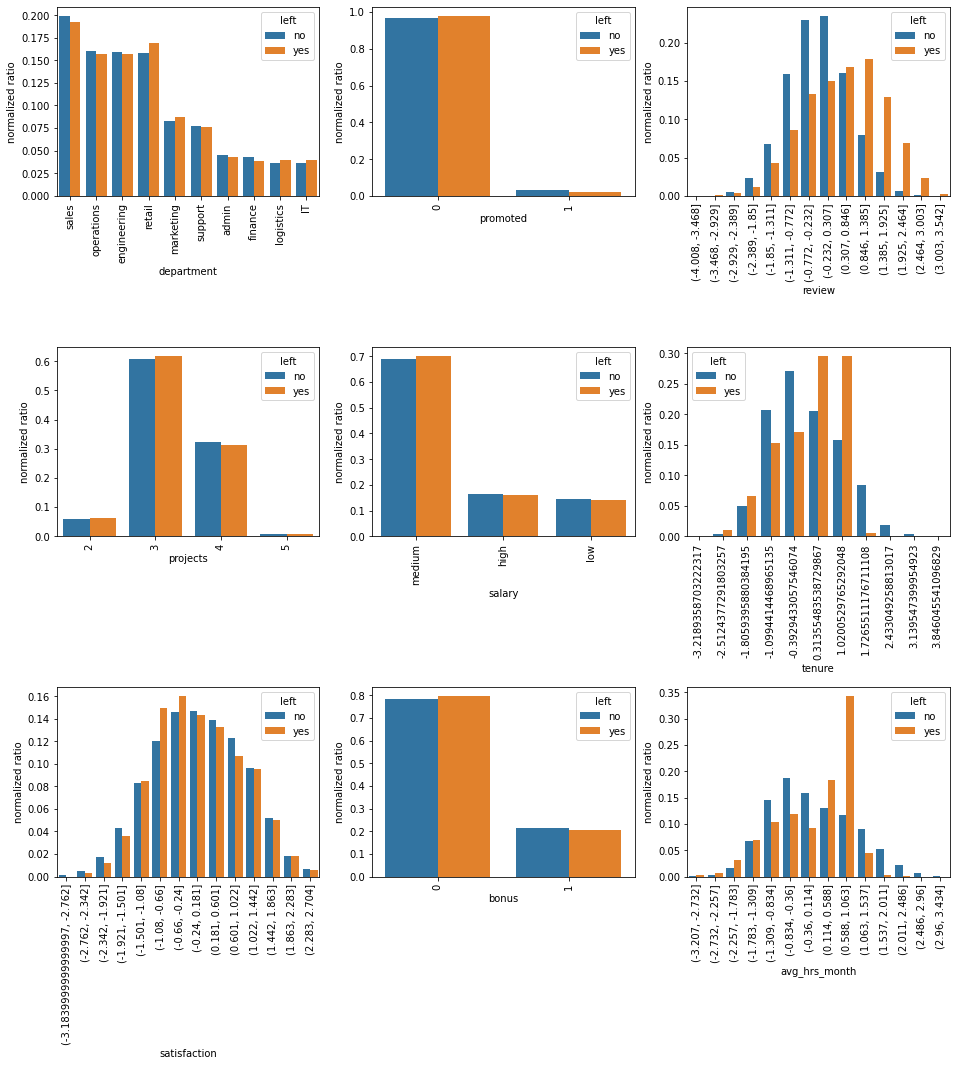

In [3]:
# figure formatting options
fig, ax = plt.subplots(3,3, sharex=False, figsize = [16,16] )

#fig.tight_layout(pad=8.0)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.8)


for n,i in enumerate(df.columns[0:-1]):
    #catches and handles categorical data:
    if df[i].nunique() < 20:
        #any variable with less than 20 unique variables is considered "categorical" 
        temp_df = (df.groupby(['left'])[i].value_counts(normalize = True).rename('normalized ratio').reset_index())
        plt.sca(ax[n//3][n%3])
        sns.barplot(x = i, y = 'normalized ratio', hue = 'left', data = temp_df)
        plt.xticks(rotation = 'vertical')
    else:
        bins = np.arange(start = df[i].min(), stop = df[i].max(), step = (df[i].max() - df[i].min()) / 15) 
        temp_df = (df.groupby(['left'])[i].value_counts(normalize = True, bins = bins, sort = False).rename('normalized ratio').reset_index())
        plt.sca(ax[n//3][n%3])
        sns.barplot(x = i , y = 'normalized ratio', hue = 'left', data = temp_df)
        plt.xlabel(i)
        plt.xticks(rotation = 'vertical')
    

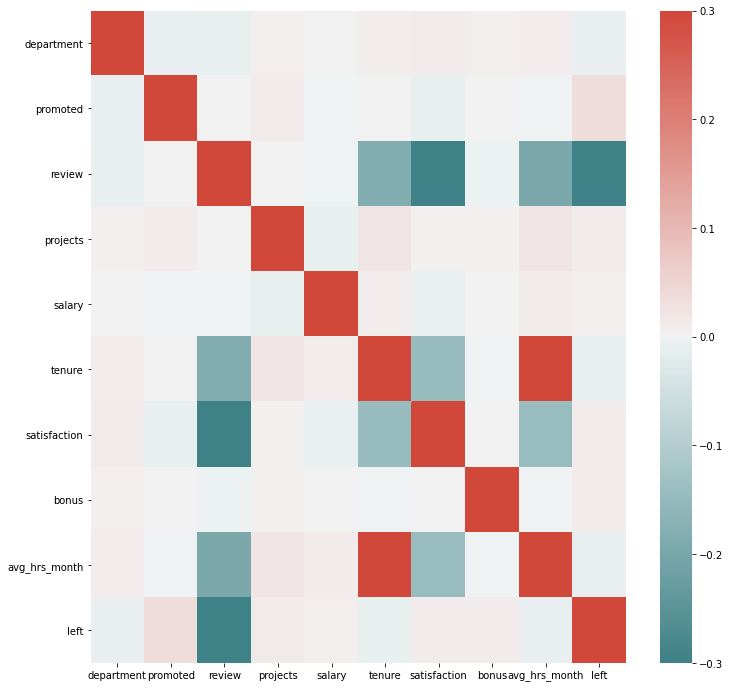

In [4]:
# creating a numerical dataset:
df_num = df.copy(deep = True)

#set of caterogical data:
col_cat = ['department', 'salary', 'left']

#change values to numerical placeholder:

for i in col_cat:
    #define array numerical array to represent categorical data:
    df_num[i] = pd.get_dummies(df[i])

#drawing correlation map:
fig2 = f = plt.figure()
fig2.set_figwidth(12)
fig2.set_figheight(12)

heatC = sns.diverging_palette(200, 15, as_cmap=True)
_ = sns.heatmap(df_num.corr(),cmap=heatC, vmax=.3, vmin = -.3)

In [5]:
# dividing data into train and test sets:
df_bayes  = df_num.copy()

#the test set is 90% of total data:
train, test = train_test_split(df_bayes, test_size=0.1, random_state=26)

#accuracy if we assume nobody leaves:
base_acc = (len(test[test['left'] == 1]) / len(test)) * 100
print('The accuracy of the null classifier is ' + "{0:.2f}".format(base_acc) + '%.')    

The accuracy of the null classifier is 69.71%.


In [6]:
#Implementation of Gaussian naive Bayes:
glf = GaussianNB()
glf.fit(train.iloc[:,0:-1], train.iloc[:,-1])


#running gaussian naive bayes after dropping categorical features:
drop_vars    = ['department','promoted', 'projects', 'salary', 'bonus']
train_sub    = train.drop(columns = drop_vars)
test_sub     = test.drop(columns = drop_vars)

glf_sub      = GaussianNB()
glf_sub.fit(train_sub.iloc[:,0:-1], train_sub.iloc[:,-1])

#print(glf_sub.score(train_sub.iloc[:,0:-1], train_sub.iloc[:,-1]))
glf_acc   = (glf_sub.score(test_sub.iloc[:,0:-1], test_sub.iloc[:,-1]))*100
glf_acc_2 = (glf_sub.score(train_sub.iloc[:,0:-1], train_sub.iloc[:,-1]))*100

print('Gaussian Naive bayes performed on quantitaive features:' )
print('Training accuracy is: ' + '{0:.2f}'.format(glf_acc_2)+ '%.')
print('Model accuracy rate, trained using quantitaive variables, is: ' + '{0:.2f}'.format(glf_acc)+ '%.')


Gaussian Naive bayes performed on quantitaive features:
Training accuracy is: 74.40%.
Model accuracy rate, trained using quantitaive variables, is: 74.42%.


In [7]:
#Naive Bayes after considering both quantitaive and caterogical data:
quan_vars = ['review', 'tenure', 'satisfaction', 'avg_hrs_month']

train_c   = train.drop(columns = quan_vars)
test_c    = test.drop(columns = quan_vars)

clf = CategoricalNB()
clf.fit(train_c.iloc[:,0:-1], train_c.iloc[:,-1])

#clf_acc = (clf.score(test_c.iloc[:,0:-1], test_c.iloc[:,-1]))*100

def mlf_fit(X):
    X_cat   = X.drop(columns = quan_vars) 
    X_quant = X.drop(columns = drop_vars)
    cat_m   = clf.predict_log_proba(X_cat)
    quant_m = glf_sub.predict_log_proba(X_quant)   
    
    #calculating the log probablilities of keft = yes or no:
    ovrl    = ( cat_m + quant_m ) /2
    return ovrl

def mlf_score(X, y):
    log_prob_comb = mlf_fit(X)
    yes_print = []
    for i in log_prob_comb:
        if i[0] > i[1]:
            yes_print.append(0)
        else:
            yes_print.append(1)
            
    corr_count = 0
    for n, i in enumerate(yes_print):
        if i == y.iloc[n]:
            corr_count = corr_count + 1  
            
    return corr_count / len(y)


mlf_acc   = (mlf_score(train.iloc[:,0:-1], train.iloc[:,-1]))*100
mlf_acc_2 = (mlf_score(test.iloc[:,0:-1], test.iloc[:,-1]))*100

print('Hybrid Naive Bayes performed using Gaussian Naive Bayes and Categorical Naive Bayes (includes all 9 features):' )
print('Training accuracy is: ' + '{0:.2f}'.format(mlf_acc_2)+ '%.')
print('Model accuracy rate, trained using quantitaive variables, is: ' + '{0:.2f}'.format(mlf_acc)+ '%.')


Hybrid Naive Bayes performed using Gaussian Naive Bayes and Categorical Naive Bayes (includes all 9 features):
Training accuracy is: 72.01%.
Model accuracy rate, trained using quantitaive variables, is: 72.63%.


Using SVMs:

In [8]:
# defining a linear SVM:
lin_svm = svm.SVC(kernel = 'linear')
lin_svm.fit(train_sub.iloc[:,0:-1], train_sub.iloc[:,-1])

# fitting a SVM using RBF kernel
rbf_svm = svm.SVC(kernel = 'rbf', gamma = 1, C = 10**-2)
rbf_svm.fit(train_sub.iloc[:,0:-1], train_sub.iloc[:,-1])


SVC(C=0.01, gamma=1)

In [9]:
lin_acc   = (lin_svm.score(test_sub.iloc[:,0:-1], test_sub.iloc[:,-1]))*100
lin_acc_2 = (lin_svm.score(train_sub.iloc[:,0:-1], train_sub.iloc[:,-1]))*100

rbf_acc   = (rbf_svm.score(test_sub.iloc[:,0:-1], test_sub.iloc[:,-1]))*100
rbf_acc_2 = (rbf_svm.score(train_sub.iloc[:,0:-1], train_sub.iloc[:,-1]))*100

#printing results:

print('Linear SVM performed on quantitaive features:' )
print('Training accuracy is: ' + '{0:.2f}'.format(lin_acc_2)+ '%.')
print('Model accuracy rate, trained using quantitaive variables, is: ' + '{0:.2f}'.format(lin_acc)+ '%.')


print('SVM using RBF kernel on quantitaive features:' )
print('Training accuracy is: ' + '{0:.2f}'.format(rbf_acc_2)+ '%.')
print('Model accuracy rate, trained using quantitaive variables, is: ' + '{0:.2f}'.format(rbf_acc)+ '%.')

#storing the support vectors points in a data frame:
support_vecs = pd.DataFrame(rbf_svm.support_vectors_, columns = quan_vars)
support_vecs['y'] = rbf_svm.predict(rbf_svm.support_vectors_)

print(support_vecs.head())

Linear SVM performed on quantitaive features:
Training accuracy is: 70.94%.
Model accuracy rate, trained using quantitaive variables, is: 69.71%.
SVM using RBF kernel on quantitaive features:
Training accuracy is: 83.37%.
Model accuracy rate, trained using quantitaive variables, is: 83.44%.
     review    tenure  satisfaction  avg_hrs_month  y
0  0.918494 -1.805940     -0.182855      -1.699204  1
1  0.627642  1.020053     -0.493196       1.032742  1
2  1.152708 -1.099441     -1.001211      -1.241043  0
3  2.190376 -1.099441     -0.695444      -0.840132  0
4  1.644120  0.313555     -1.189238       0.079212  1


In [ ]:
_ = sns.pairplot(support_vecs, hue = 'y', kind = 'scatter', palette = 'deep' , plot_kws={'alpha' : 0.5}, markers = ['+', 'x'])
#_ = sns.scatterplot(x = 'review', y = 'satisfaction', style = 'y', hue = 'y', data = support_vecs, markers =  {0: '+', 1 : 'x'}, alpha = 0.2)

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) 
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = support_vecs['review']
y = support_vecs['avg_hrs_month']
z = support_vecs['satisfaction']
#z = support_vecs['tenure']

ax.scatter(x, y, z, c=support_vecs['y'], marker='o')
ax.set_xlabel('review')
ax.set_ylabel('avg_hrs_month')
ax.set_zlabel('satisfaction')

plt.show()

## 💪 Competition challenge

Create a report that covers the following:
1. Which department has the highest employee turnover? Which one has the lowest?
2. Investigate which variables seem to be better predictors of employee departure.
3. What recommendations would you make regarding ways to reduce employee turnover?